In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import hyperspy

In [2]:
import matplotlib
matplotlib.rcParams["backend"] = "Qt4Agg"

In [3]:
from traits.etsconfig.api import ETSConfig
ETSConfig.toolkit = 'qt4'
%matplotlib notebook
import hyperspy.api as hs

/opt/anaconda3/envs/hsenv2/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


In [4]:
specimen = 3
if specimen == 3:
    ZLPs = np.load("ZLPs_13_sp3.npy")
    data_14 = np.load("sample_data_13_sp3.npy")
else:
    data_14 = np.load("sample_data_14.npy")
    ZLPs = np.load("ZLPs_14.npy")

In [5]:
data_14.shape

(2000, 2)

In [6]:
s = hs.signals.Signal1D(data_14[:,1])
energy_data = data_14[:,0]
s.axes_manager[0].scale = np.diff(energy_data).mean()
s.axes_manager[0].units = 'keV'
s.axes_manager[0].offset = energy_data[0]
s.axes_manager[0].name = 'Energy'
s.axes_manager

Signal axis name,size,offset,scale,units
Energy,2000,-0.9304652326163081,0.0050025012506253125,keV


In [98]:
ZLP_avg = np.average(ZLPs, axis = 0)
N_ZLP = np.sum(ZLP_avg)

In [111]:
s = s.isig[0.005:]
s.set_signal_type('EELS')
s.set_microscope_parameters(beam_energy=200, collection_angle=30)
eps, out = s.kramers_kronig_analysis(zlp = N_ZLP, n = 3, full_output = True, iterations = 4)
s.axes_manager

Signal axis name,size,offset,scale,units
Energy,1813,0.0050025012506253125,0.0050025012506253125,keV


thickness:  [12.4724295] nm


<IPython.core.display.Javascript object>


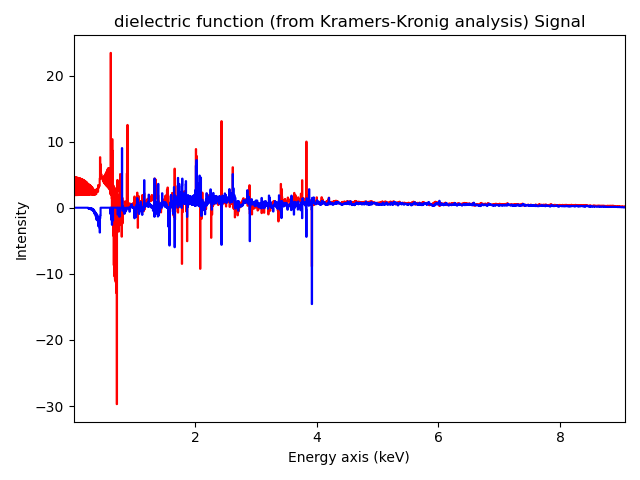

In [112]:
print('thickness: ', out['thickness'].data, 'nm')
eps.plot()

thickness:  [16.87121759] nm


<IPython.core.display.Javascript object>


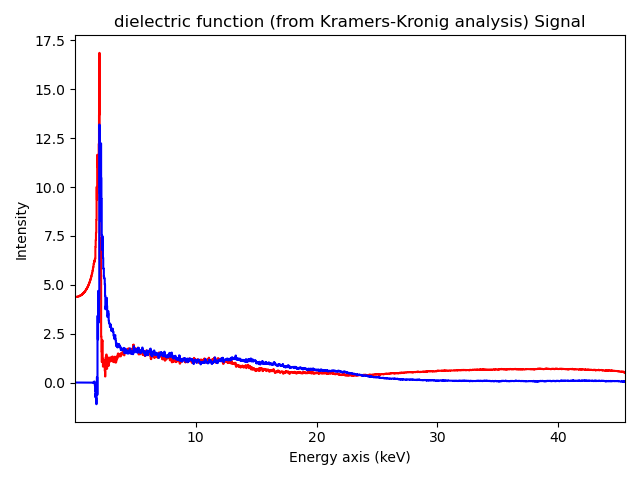

In [31]:
specimen = 4
if specimen == 3:
    ZLPs = np.load("ZLPs_13_sp3.npy")
    data_14 = np.load("sample_data_13_sp3.npy")
else:
    data_14 = np.load("sample_data_14.npy")
    ZLPs = np.load("ZLPs_14.npy")
s = hs.signals.Signal1D(data_14[:,1])
energy_data = data_14[:,0]
s.axes_manager[0].scale = np.diff(energy_data).mean()
s.axes_manager[0].units = 'keV'
s.axes_manager[0].offset = energy_data[0]
s.axes_manager[0].name = 'Energy'
s.axes_manager
ZLP_avg = np.average(ZLPs, axis = 0)
N_ZLP = np.sum(ZLP_avg)
s.set_signal_type('EELS')
s.set_microscope_parameters(beam_energy=200, collection_angle=30)
eps, out = s.kramers_kronig_analysis(zlp = N_ZLP, n = 3, full_output = True)#, iterations = 2)
print('thickness: ', out['thickness'].data, 'nm')
eps.plot()

<IPython.core.display.Javascript object>


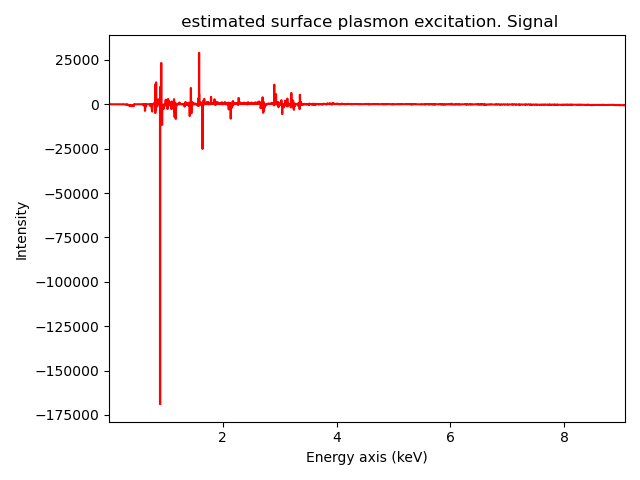

In [116]:
out['surface plasmon estimation'].plot()

In [36]:
np.save("hs_og_eps_14",eps.data)

In [47]:
axis = s.axes_manager.signal_axes[0]
l = axis.size

In [48]:
slicer = s.axes_manager._get_data_slice(
            [(axis.index_in_array, slice(None, axis.size)), ])

In [49]:
import scipy
esize = scipy.fftpack.next_fast_len(2*l)

In [114]:
import numbers
import logging 
_logger = logging.getLogger(__name__)
def optimal_fft_size(target, real=False):
    """Wrapper around scipy function next_fast_len() for calculating optimal FFT padding.

    scipy.fft was only added in 1.4.0, so we fall back to scipy.fftpack
    if it is not available. The main difference is that next_fast_len()
    does not take a second argument in the older implementation.

    Parameters
    ----------
    target : int
        Length to start searching from. Must be a positive integer.
    real : bool, optional
        True if the FFT involves real input or output, only available
        for scipy > 1.4.0

    Returns
    -------
    int
        Optimal FFT size.

    """

    try:
        from scipy.fft import next_fast_len

        support_real = True

    except ImportError:
        from scipy.fftpack import next_fast_len

        support_real = False

    if support_real:
        return next_fast_len(target, real)
    else:
        return next_fast_len(target)

def kramers_kronig_analysis_new(s,
                                zlp=None,
                                iterations=1,
                                n=None,
                                t=None,
                                delta=0.5,
                                full_output=False, prints = np.array([])):
    output = {}
    if iterations == 1:
        # In this case s.data is not modified so there is no need to make
        # a deep copy.
        s = s.isig[0.:]
    else:
        s = s.isig[0.:].deepcopy()

    sorig = s.isig[0.:]
    if 1 in prints: print("1, ", s.axes_manager.signal_axes[0])
    # Avoid singularity at 0
    if s.axes_manager.signal_axes[0].axis[0] == 0:
        s = s.isig[1:]
        sorig = s.isig[1:]
    if 2 in prints: print("2, ", s.axes_manager.signal_axes[0])

    # Constants and units
    me = 511.06#constants.value(
    #    'electron mass energy equivalent in MeV') * 1e3  # keV

    # Mapped parameters
    s._are_microscope_parameters_missing(
        ignore_parameters=['convergence_angle'])
    e0 = s.metadata.Acquisition_instrument.TEM.beam_energy
    beta = s.metadata.Acquisition_instrument.TEM.Detector.EELS.\
        collection_angle

    axis = s.axes_manager.signal_axes[0]
    eaxis = axis.axis.copy()
    if 3 in prints: print("3, ", eaxis)

    if isinstance(zlp, hyperspy.signal.BaseSignal):
        if (zlp.axes_manager.navigation_dimension ==
                s.axes_manager.navigation_dimension):
            if zlp.axes_manager.signal_dimension == 0:
                i0 = zlp.data
            else:
                i0 = zlp.integrate1D(axis.index_in_axes_manager).data
        else:
            raise ValueError('The ZLP signal dimensions are not '
                             'compatible with the dimensions of the '
                             'low-loss signal')
        # The following prevents errors if the signal is a single spectrum
        if len(i0) != 1:
            i0 = i0.reshape(
                np.insert(i0.shape, axis.index_in_array, 1))
    elif isinstance(zlp, numbers.Number):
        i0 = zlp
    else:
        raise ValueError('The zero-loss peak input is not valid, it must be\
                         in the BaseSignal class or a Number.')

    if isinstance(t, hyperspy.signal.BaseSignal):
        if (t.axes_manager.navigation_dimension ==
                self.axes_manager.navigation_dimension) and (
                t.axes_manager.signal_dimension == 0):
            t = t.data
            t = t.reshape(
                np.insert(t.shape, axis.index_in_array, 1))
        else:
            raise ValueError('The thickness signal dimensions are not '
                             'compatible with the dimensions of the '
                             'low-loss signal')
    elif isinstance(t, np.ndarray) and t.shape and t.shape != (1,):
        raise ValueError("thickness must be a HyperSpy signal or a number,"
                         " not a numpy array.")

    # Slicer to get the signal data from 0 to axis.size
    slicer = s.axes_manager._get_data_slice(
        [(axis.index_in_array, slice(None, axis.size)), ])
    print(slicer)
    
    # Kinetic definitions
    ke = e0 * (1 + e0 / 2. / me) / (1 + e0 / me) ** 2
    tgt = e0 * (2 * me + e0) / (me + e0)
    rk0 = 2590 * (1 + e0 / me) * np.sqrt(2 * ke / me)
    
    for io in range(iterations):
        # Calculation of the ELF by normalization of the SSD
        # Norm(SSD) = Imag(-1/epsilon) (Energy Loss Funtion, ELF)

        # We start by the "angular corrections"
        Im = s.data / (np.log(1 + (beta * tgt / eaxis) ** 2)) / axis.scale
        if n is None and t is None:
            raise ValueError("The thickness and the refractive index are "
                             "not defined. Please provide one of them.")
        elif n is not None and t is not None:
            raise ValueError("Please provide the refractive index OR the "
                             "thickness information, not both")
        elif n is not None:
            # normalize using the refractive index.
            K = (Im / eaxis).sum(axis=axis.index_in_array, keepdims=True) \
                * axis.scale
            if 16 in prints: print("16, ", K)
            K = (K / (np.pi / 2) / (1 - 1. / n ** 2))
            if 17 in prints: print("17, ", K)
            # K = (K / (np.pi / 2) / (1 - 1. / n ** 2)).reshape(
            #    np.insert(K.shape, axis.index_in_array, 1))
            # Calculate the thickness only if possible and required
            if zlp is not None and (full_output is True or
                                    iterations > 1):
                te = (332.5 * K * ke / i0)
                if full_output is True:
                    output['thickness'] = te
        elif t is not None:
            if zlp is None:
                raise ValueError("The ZLP must be provided when the  "
                                 "thickness is used for normalization.")
            # normalize using the thickness
            K = t * i0 / (332.5 * ke)
            te = t
        Im = Im / K

        # Kramers Kronig Transform:
        # We calculate KKT(Im(-1/epsilon))=1+Re(1/epsilon) with FFT
        # Follows: D W Johnson 1975 J. Phys. A: Math. Gen. 8 490
        # Use an optimal FFT size to speed up the calculation, and
        # make it double the closest upper value to workaround the
        # wrap-around problem.
        esize = optimal_fft_size(2 * axis.size)
        if 4 in prints: print("4, ", esize)
        q = -2 * np.fft.fft(Im, esize,
                            axis.index_in_array).imag / esize
        if 5 in prints: print("5, ", q)
        q[slicer] *= -1
        if 6 in prints: print("6, ", q)
        if 7 in prints: print("7, ", q[1800:1840])
        q = np.fft.fft(q, axis=axis.index_in_array)
        # Final touch, we have Re(1/eps)
        Re = q[slicer].real + 1
        if 8 in prints: print("8, ", q)
        if 9 in prints: print("9, ", q[1800:1840])
        if 10 in prints: print("10, ", Re)
        # Egerton does this to correct the wrap-around problem, but in our
        # case this is not necessary because we compute the fft on an
        # extended and padded spectrum to avoid this problem.
        # Re=real(q)
        # Tail correction
        # vm=Re[axis.size-1]
        # Re[:(axis.size-1)]=Re[:(axis.size-1)]+1-(0.5*vm*((axis.size-1) /
        #  (axis.size*2-arange(0,axis.size-1)))**2)
        # Re[axis.size:]=1+(0.5*vm*((axis.size-1) /
        #  (axis.size+arange(0,axis.size)))**2)

        # Epsilon appears:
        #  We calculate the real and imaginary parts of the CDF
        e1 = Re / (Re ** 2 + Im ** 2)
        e2 = Im / (Re ** 2 + Im ** 2)

        if iterations > 1 and zlp is not None:
            # Surface losses correction:
            #  Calculates the surface ELF from a vaccumm border effect
            #  A simulated surface plasmon is subtracted from the ELF
            Srfelf = 4 * e2 / ((e1 + 1) ** 2 + e2 ** 2) - Im
            adep = (tgt / (eaxis + delta) *
                    np.arctan(beta * tgt / axis.axis) -
                    beta / 1000. /
                    (beta ** 2 + axis.axis ** 2. / tgt ** 2))
            Srfint = 2000 * K * adep * Srfelf / rk0 / te * axis.scale
            if 11 in prints: print("11, ", Srfelf)
            if 12 in prints: print("12, ", adep)
            if 13 in prints: print("13, ", Srfint)
            if 14 in prints: print("14, ", Srfint[300:320])
            if 15 in prints: print("15, ", K, rk0, te, axis.scale)
            s.data = sorig.data - Srfint
            _logger.debug('Iteration number: %d / %d', io + 1, iterations)
            if iterations == io + 1 and full_output is True:
                sp = sorig._deepcopy_with_new_data(Srfint)
                sp.metadata.General.title += (
                    " estimated surface plasmon excitation.")
                output['surface plasmon estimation'] = sp
                del sp
            del Srfint

    eps = s._deepcopy_with_new_data(e1 + e2 * 1j)
    #del s
    eps.set_signal_type("DielectricFunction")
    eps.metadata.General.title = (s.metadata.General.title +
                                  'dielectric function '
                                  '(from Kramers-Kronig analysis)')
    if eps.tmp_parameters.has_item('filename'):
        eps.tmp_parameters.filename = (
            s.tmp_parameters.filename +
            '_CDF_after_Kramers_Kronig_transform')
    if 'thickness' in output:
        # As above,prevent errors if the signal is a single spectrum
        if len(te) != 1:
            te = te[self.axes_manager._get_data_slice(
                    [(axis.index_in_array, 0)])]
        thickness = eps._get_navigation_signal(data=te)
        thickness.metadata.General.title = (
            s.metadata.General.title + ' thickness '
            '(calculated using Kramers-Kronig analysis)')
        output['thickness'] = thickness
    if full_output is False:
        return eps
    else:
        return eps, output

In [117]:
eps_2, out_2 = kramers_kronig_analysis_new(s, zlp = N_ZLP, n = 3, full_output = True, prints = range(13,26), iterations =4)

(slice(None, 1813, None),)
16,  [26779.79593735]
17,  [19179.6160429]
13,  [   0.            0.            0.         ... -360.94441974 -399.02466717
 -413.25632074]
14,  [ 185.38761961  174.87042717  258.19732497  332.2118947   304.54921632
  227.41648689    0.           63.22826167  263.83030997  138.4973919
   98.3993495   472.11959714   58.65716662  960.21378935 1062.85270381
  776.6998495  1142.67117953 1116.18566586 1098.78442345  880.81029456]
15,  [19179.6160429] 2505.531095248551 [12.03963716] 0.0050025012506253125
16,  [17295.79340508]
17,  [12387.19956802]
13,  [   0.            0.            0.         ... -747.06576786 -826.13310525
 -844.40053725]
14,  [  282.21402103   214.399235      17.23476379   196.31348536
   110.40098188   319.55066025     0.           -28.64863826
  -110.56137286   -36.81296886   -58.0926559   -334.96263499
   -25.55837601  -488.96331184 -1580.52673663  -697.07357696
 -1639.24051642 -2059.35646686 -2560.42026649  1460.01401372]
15,  [12387.1995680

<IPython.core.display.Javascript object>


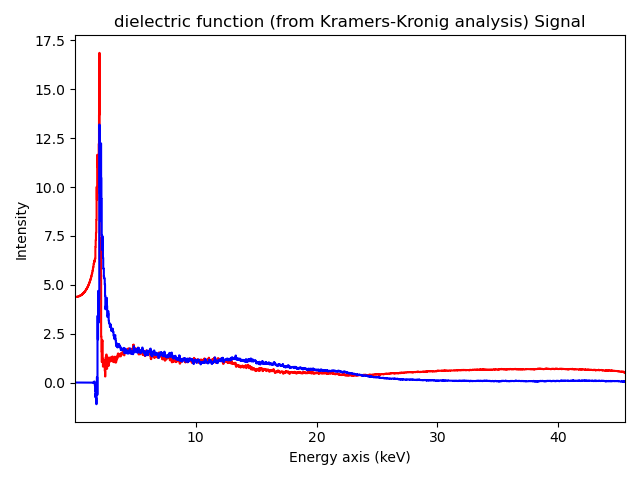

In [72]:
eps_2.plot()

In [77]:
3 in range(4)

True